In [1]:
import psycopg2
from collections import defaultdict

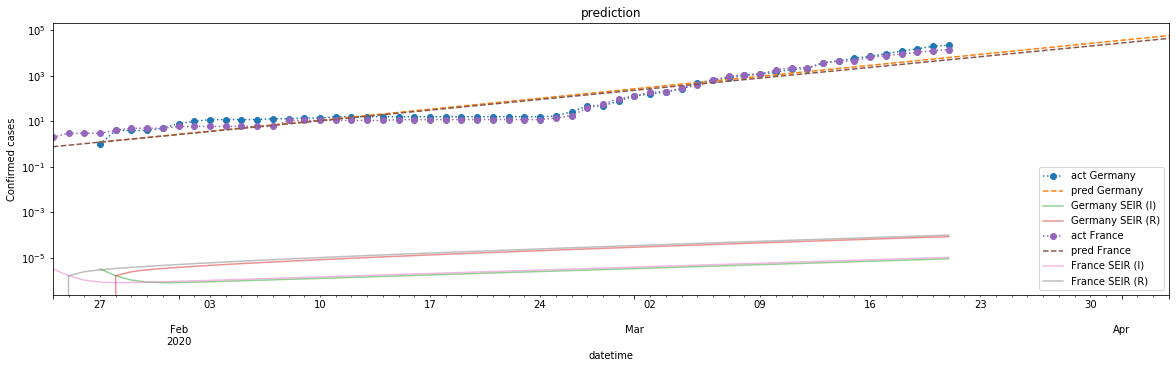

Coefficient of determination: {'Germany': 0.8777177210364107, 'France': 0.8785059427162796}
Evolution factor per day: {'Germany': 1.4, 'France': 1.4}


In [266]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
import matplotlib.dates as dates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

class Analyse:
    def startAnalyse(df, countries, yLabel, yColumn):
        df = df[(df["Value"]>0)] #suppress data with no cases (before begin of epidemy)
        X = {}
        convertedX = {}
        y = {}
        y_log = {}
        regressor = {}
        model = {}
        r_sq = {}
        X_pred = {}
        y_pred = {}
        y_SEIR = {}
        
        coeff = {}
        dailyCoeff = {}
        
        output = {'Italy': {}, 'France': {}, 'Germany': {}}

        for country in countries:
            # Select data
            X[country] = df[df["Country/Region"]==country][["update"]].copy()
            convertedX[country] = X[country].copy()
            convertedX[country]["update"] = convertedX[country]["update"].astype(int)
            ## for backwards conversion to datetime: pd.to_datetime(X["update"].astype(int))
            y[country] = df[df["Country/Region"]==country][yColumn]
            y_log[country] = np.log(df[df["Country/Region"]==country][yColumn])
            # Create model
            regressor[country] = LinearRegression()
            model[country] = regressor[country].fit(convertedX[country], y_log[country])
            r_sq[country] = model[country].score(convertedX[country], y_log[country])
            coeff[country] = regressor[country].coef_[0]
            dailyCoeff[country] = round(10**(3600*24*(10**9)*regressor[country].coef_[0]), 1)
            #print(country)
            #print('intercept:', model[country].intercept_)
            #print('slope:', model[country].coef_[0])

            # Generate prediction: regressor.predict(convertedX)
            X_pred[country] = pd.DataFrame([
                X[country].min(), 
                X[country].min() + pd.Timedelta(1, unit='d'), 
                X[country].min() + pd.Timedelta(2, unit='d'), 
                X[country].min() + pd.Timedelta(3, unit='d'), 
                X[country].min() + pd.Timedelta(4, unit='d'), 
                X[country].min() + pd.Timedelta(5, unit='d'), 
                X[country].min() + pd.Timedelta(6, unit='d'), 
                X[country].min() + pd.Timedelta(7, unit='d'),
                X[country].max() + pd.Timedelta(1, unit='d'),
                X[country].max() + pd.Timedelta(2, unit='d'),
                X[country].max() + pd.Timedelta(3, unit='d'),
                X[country].max() + pd.Timedelta(4, unit='d'),
                X[country].max() + pd.Timedelta(5, unit='d'),
                X[country].max() + pd.Timedelta(6, unit='d'),
                X[country].max() + pd.Timedelta(7, unit='d'),
                X[country].max() + pd.Timedelta(8, unit='d'),
                X[country].max() + pd.Timedelta(9, unit='d'),
                X[country].max() + pd.Timedelta(10, unit='d'),
                X[country].max() + pd.Timedelta(11, unit='d'),
                X[country].max() + pd.Timedelta(12, unit='d'),
                X[country].max() + pd.Timedelta(13, unit='d'),
                X[country].max() + pd.Timedelta(14, unit='d')])
            y_pred[country] = np.exp(regressor[country].predict(X_pred[country].astype(int)))
            
            
            
            
            
        # Plot result
        fig, ax = plt.subplots(ncols=1, nrows=1)
        ax.set_yscale("log")
        #ax.set_ylim(1,10000)

        ax.grid(True, which="minor", axis="y", color='g', linestyle='--', linewidth=1,alpha=0.3)
        ax.grid(True, which="major", axis="y", color='g', linestyle='-', linewidth=2,alpha=0.3)

        ax.xaxis.set_minor_locator(dates.DayLocator(bymonthday=range(1,32), interval=1))
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%d'))
        ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=0))
        ax.xaxis.set_major_formatter(dates.DateFormatter('\n%m-%d'))
        ax.grid(True, which="major", axis="x", color='g', linestyle='-', linewidth=2)
        fig.set_size_inches(20,5)
        for country in countries:
            plotDf = pd.DataFrame(X[country])
            
            
            plotDf["y"]=y[country]
            
            plotDf.plot(x="update", y="y", ax=ax, style="o:", label="act "+country)     
            
            
            plotDf_pred = pd.DataFrame(X_pred[country])
            plotDf_pred["y"]=y_pred[country]
            plotDf_pred.plot(x="update", y="y", ax=ax, style="--", label="pred "+country)
            #plt.plot(X[country], y[country], "ro")
            #plt.plot(X_pred[country][["update"]], y_pred[country], "b--")
            plotDf.set_index('update', inplace=True)
            plotDf_pred.set_index('update', inplace=True)
            #plotDf['predicted'] = plotDf_pred['y']
            #output[country]['real_value'] = plotDf
            #output[country]['predicted_value'] = plotDf_pred
            plotDf_pred.rename(columns={'y': 'predicted'}, inplace=True)
            output[country] = pd.merge(plotDf, plotDf_pred, on='update', how='outer').reset_index()
            
            
            #--------------------------------------------------------------------------------
            ## ==== Added by ABM for the SEIR comparison
            plotDf["TS"] = plotDf.index.tolist()
            y_SEIR[country] = Analyse.SEIR(None, None, None, plotDf.index.tolist())
            
            plotDf["y_SEIR_I"] = y_SEIR[country]["I"].values
            plotDf["y_SEIR_R"] = y_SEIR[country]["R"].values
            
            plotDf.iloc[:].plot(x="TS",y="y_SEIR_I",ax=ax,style="-",label=f"{country} SEIR (I)",alpha=0.5)
            plotDf.iloc[:].plot(x="TS",y="y_SEIR_R",ax=ax,style="-",label=f"{country} SEIR (R)",alpha=0.5)
            #-------------------------------------------------------------------------------------
            
        plt.title('prediction')
        plt.xlabel('datetime')
        plt.ylabel(yLabel)
        plt.legend()
        plt.show()

        print('Coefficient of determination:', r_sq)
        print("Evolution factor per day: {}".format(dailyCoeff))
        #print("Evolution factor per 2 days: {}".format(round(10**(3600*24*2*(10**9)*regressor[country].coef_[0]), 1)))
        #print("Evolution factor per 3 days: {}".format(round(10**(3600*24*3*(10**9)*regressor[country].coef_[0]), 1)))
        #print("Evolution factor per week: {}".format(round(10**(3600*24*7*(10**9)*regressor[country].coef_[0]), 1)))
        #X_pred[country]["pred"] = pd.DataFrame(y_pred[country])
        #X_pred[country]["prev"] = X_pred[country].apply(
        #    lambda row: X_pred[country][X_pred[country]["update"]<row["update"]]["update"].max(), 
        #    axis=1
        #)
        #X_pred[country]["diff"] = X_pred[country].apply(
        #    lambda row: row["pred"] / X_pred[country][X_pred[country]["update"]==row["prev"]]["pred"].max(), 
        #    axis=1
        #)
        return output
    #-------------------------------------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------------------------------
    # Added by ABM for the SEIR model
    def SEIR(N, init_vals=None, params=None, t=None):
        """
        Original source:
        https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
        
        Parameters:
        init_values: a list of 4 values for the initial S, E, I, R
        
        params:  a list of parameters [α, β, γ]
        
        where: α is the inverse of the incubation period (1/t_incubation)
        β is the average contact rate in the population
        γ is the inverse of the mean infectious period (1/t_infectious)
        
        t: number of iteration since init_vals (number of time units) 
        In our case I will also use it as a timestamp for plotting
        
        Output: A dataframe, with the S,E,I,R values for each iteration in t
        
        For the time being, we accept None for the parameters in order to test the graph only        
        """
        
        if N is None: N = 60e6
        
        if init_vals is None:
            ii = 200
            init_vals=[(N - ii)/N, 0/N , ii/N ,0/N]
        if params is None:
                params = [0.08,0.9,0.5]
        if t is None:
                t=range(100)
                
        S_0, E_0, I_0, R_0 = init_vals
        S, E, I, R = [S_0], [E_0], [I_0], [R_0]
        alpha, beta, gamma = params
        dt = int((t[1] - t[0]).days)        
        # usually one day in our case
        
        for _ in t[1:]:
            next_S = S[-1] - (beta*S[-1]*I[-1]) * dt
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_R = R[-1] + (gamma*I[-1])*dt
            S.append(next_S)
            E.append(next_E)
            I.append(next_I)
            R.append(next_R)
        
        result = np.stack([S, E, I, R]).T
        df = pd.DataFrame(result,columns=["S","E","I","R"])        
        df["update"] = t
        return df
    #-------------------------------------------------------------------------------------------------------------
    def SIR(N, I0,R0, alpha, beta,gamma ,t):
        """
        N : Population size
        I0 : infected initially
        R0 : recovered initially
        beta: contact rate
        gamma : recovery rate
        t : timestamps
        """
        from scipy.integrate import odeint
        if N is None: N = 60e6            
        if I0 is None: I0 = 200
        if R0 is None: R0 = 0
        if alpha is None: alpha = 0 # contact rate
        if beta is None: beta = 0.7 # contact rate
        if gamma is None: gamma = 0.5 # recovered initially            
        if t is None: t = np.linspace(0,90,90)
        # Initial conditions vector
        E0 = 0
        S0 = N -I0 - R0
        y0 = S0, E0, I0, R0
        # Integrate the SIR equations over the time grid, t.
        ret = odeint(Analyse.deriv, y0, t, args=(N,alpha, beta, gamma))
        S, E, I, R = ret.T
        df = pd.DataFrame(ret,columns=["S","E","I","R"])
        return df
    
    def deriv(y, t, N, alpha, beta, gamma):
        S,E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = alpha * I
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt
    #-------------------------------------------------------------------------------------------------------------
    
#-----------------------------------------------------------------------------------------------------------------
## ABM Quick testing
#output = Analyse.startAnalyse(
#    Pivot(confirmedDf),
#    ["Germany","France"],
#    "Confirmed cases", 
#    "Value"
#)
Analysis.SIR()


In [3]:
import requests
import io

# Load data from url
def loadData(url):
    urlData = requests.get(url).content
    return pd.read_csv(io.StringIO(urlData.decode('utf-8')))
# Pivoting
def Pivot(df):
    # Exclude outside Europe
    df = df[
        (df["Lat"]>40) & (df["Lat"]<55)
        & (df["Long"]>0) & (df["Long"]<27)
    ]
    df = df.set_index(["Province/State", "Country/Region","Lat","Long"])
    df = df.stack().reset_index().rename(
        columns={"level_4":"Date",0:"Value"}
    )
    df["update"] = pd.to_datetime(df["Date"])
    maxDate = df["update"].max()
    df = df[
        (df["update"]>maxDate - pd.Timedelta(days=60))
    ]
    return df[df["Value"]>0][["Country/Region","update","Value"]]

In [4]:
base_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/"
confirmedUrl = "time_series_19-covid-Confirmed.csv"
deathsUrl = "time_series_19-covid-Deaths.csv"
recoveredUrl = "time_series_19-covid-Recovered.csv"

countriesSelected = ["Italy","France","Germany"]

In [5]:
confirmedDf = loadData(base_url+confirmedUrl)
deathsDf = loadData(base_url+deathsUrl)
recoveredDf = loadData(base_url+recoveredUrl)

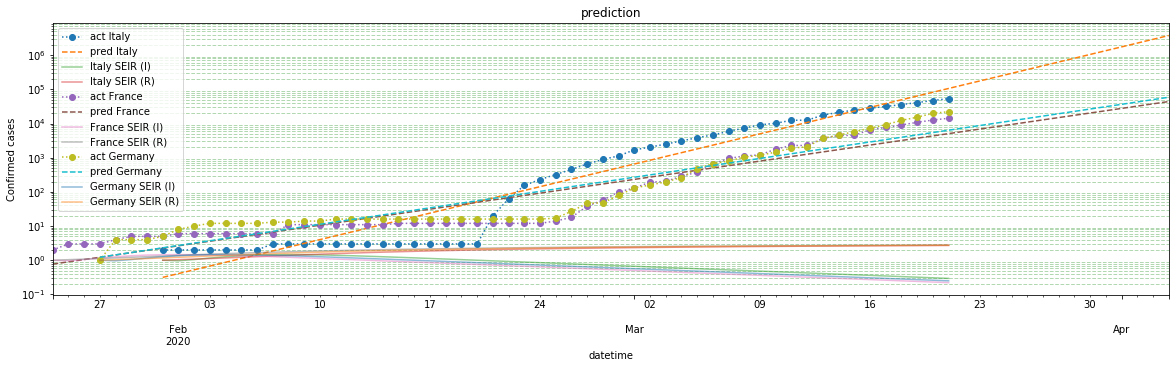

Coefficient of determination: {'Italy': 0.9277078622071253, 'France': 0.8785059427162796, 'Germany': 0.8777177210364107}
Evolution factor per day: {'Italy': 1.8, 'France': 1.4, 'Germany': 1.4}


In [221]:
output = Analyse.startAnalyse(
    Pivot(confirmedDf),
    countriesSelected,
    "Confirmed cases", 
    "Value"
)

In [7]:
output['Germany']

,update,y,predicted
0,2020-01-27,1.0,1.223919
1,2020-01-28,4.0,1.434093
2,2020-01-29,4.0,1.680359
3,2020-01-30,4.0,1.968914
4,2020-01-31,5.0,2.307021
...,...,...,...
64,2020-03-31,NaN,31083.937912
65,2020-04-01,NaN,36421.747152
66,2020-04-02,NaN,42676.177947
67,2020-04-03,NaN,50004.634774


In [13]:
r

,y,predcted
update,,
2020-01-27,1,1.223919
2020-01-28,4,1.434093
2020-01-29,4,1.680359
2020-01-30,4,1.968914
2020-01-31,5,2.307021
2020-02-01,8,2.703188
2020-02-02,10,3.167386
2020-02-03,12,3.711297
2020-02-04,12,NaN


In [3]:
connection = psycopg2.connect(user="avnadmin",
                                  password="thnj5za8epyddkxt",
                                  host="pg-e2cae57-icslecture-9af5.aivencloud.com",
                                  port="19745",
                                  database="results")

In [4]:
cur = connection.cursor()

In [5]:
table_str = """
    CREATE TABLE regression (
    date DATE NOT NULL,
    data_type VARCHAR(255) NOT NULL,
    country VARCHAR(255) NOT NULL,
    actual_value DECIMAL,
    predicted_value DECIMAL)
"""

In [6]:
cur.execute(table_str)

In [7]:
connection.commit()

In [8]:
connection.close()

In [8]:
connection = psycopg2.connect(user="avnadmin",
                                  password="thnj5za8epyddkxt",
                                  host="pg-e2cae57-icslecture-9af5.aivencloud.com",
                                  port="19745",
                                  database="results")

In [ ]:
cur = connection.cursor()

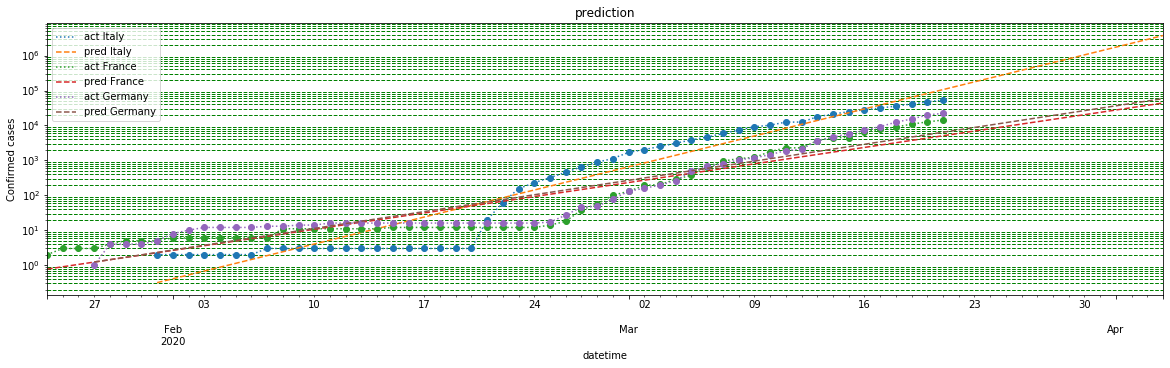

Coefficient of determination: {'Italy': 0.9277078622071253, 'France': 0.8785059427162796, 'Germany': 0.8777177210364107}
Evolution factor per day: {'Italy': 1.8, 'France': 1.4, 'Germany': 1.4}


In [9]:
output = Analyse.startAnalyse(
    Pivot(confirmedDf),
    countriesSelected,
    "Confirmed cases", 
    "Value"
)

In [10]:
for country in output.keys():
    data = output[country]
    for row in data.iterrows():
        date = row[1][0]
        y = row[1][1]
        pred = row[1][2]
        query = """INSERT INTO regression (date,
                                    data_type,
                                    country,
                                    actual_value,
                                    predicted_value) VALUES (%s,%s,%s,%s,%s)"""
        values = (date, 'Confirmed cases', country, y, pred)
        cur.execute(query, values)
        connection.commit()

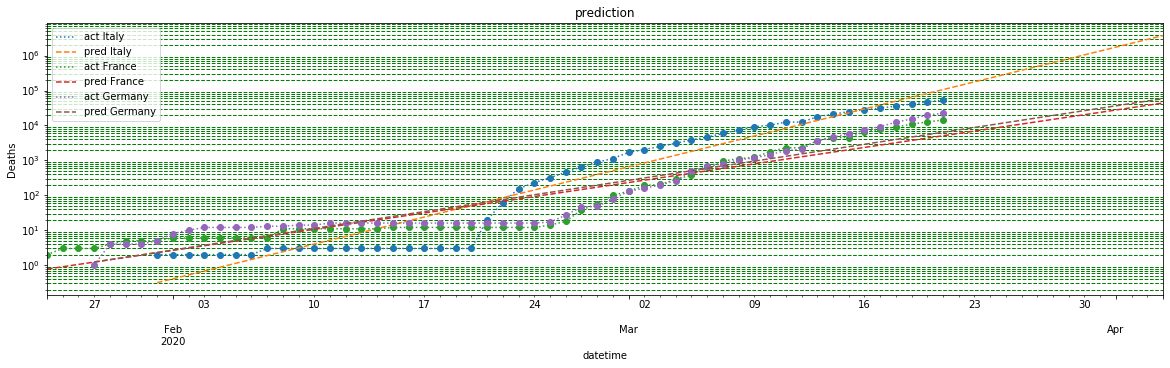

Coefficient of determination: {'Italy': 0.9277078622071253, 'France': 0.8785059427162796, 'Germany': 0.8777177210364107}
Evolution factor per day: {'Italy': 1.8, 'France': 1.4, 'Germany': 1.4}


In [11]:
output = Analyse.startAnalyse(
    Pivot(confirmedDf),
    countriesSelected,
    "Deaths", 
    "Value"
)

In [12]:
for country in output.keys():
    data = output[country]
    for row in data.iterrows():
        date = row[1][0]
        y = row[1][1]
        pred = row[1][2]
        query = """INSERT INTO regression (date,
                                    data_type,
                                    country,
                                    actual_value,
                                    predicted_value) VALUES (%s,%s,%s,%s,%s)"""
        values = (date, 'Deaths', country, y, pred)
        cur.execute(query, values)
        connection.commit()

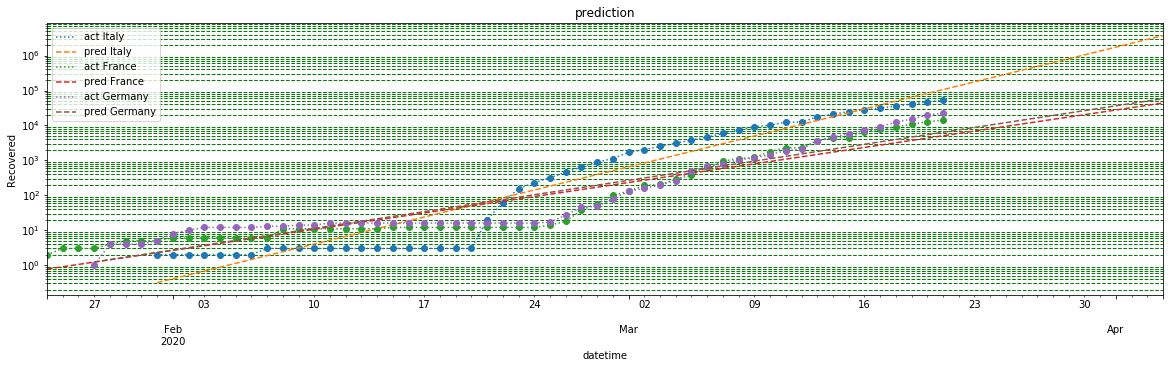

Coefficient of determination: {'Italy': 0.9277078622071253, 'France': 0.8785059427162796, 'Germany': 0.8777177210364107}
Evolution factor per day: {'Italy': 1.8, 'France': 1.4, 'Germany': 1.4}


In [13]:
output = Analyse.startAnalyse(
    Pivot(confirmedDf),
    countriesSelected,
    "Recovered", 
    "Value"
)

In [14]:
for country in output.keys():
    data = output[country]
    for row in data.iterrows():
        date = row[1][0]
        y = row[1][1]
        pred = row[1][2]
        query = """INSERT INTO regression (date,
                                    data_type,
                                    country,
                                    actual_value,
                                    predicted_value) VALUES (%s,%s,%s,%s,%s)"""
        values = (date, 'Recovered', country, y, pred)
        cur.execute(query, values)
        connection.commit()

In [16]:
connection.close()

In [26]:
connection = psycopg2.connect(user="avnadmin",
                                  password="thnj5za8epyddkxt",
                                  host="pg-e2cae57-icslecture-9af5.aivencloud.com",
                                  port="19745",
                                  database="results")

In [27]:
cur = connection.cursor()

In [28]:
table_str = """
    CREATE TABLE country_map (
    country VARCHAR(255) NOT NULL,
    country_code VARCHAR(255) NOT NULL)
"""

In [29]:
cur.execute(table_str)

In [30]:
connection.commit()

In [35]:
italy_query = """INSERT INTO country_map (
                                    country,
                                    country_code) VALUES (%s, %s)"""
italy_values = ('Italy', 'IT')
cur.execute(italy_query, italy_values)
connection.commit()

In [36]:
france_query = """INSERT INTO country_map (
                                    country,
                                    country_code) VALUES (%s, %s)"""
france_values = ('France', 'FR')
cur.execute(france_query, france_values)
connection.commit()

In [37]:
germany_query = """INSERT INTO country_map (
                                    country,
                                    country_code) VALUES (%s, %s)"""
germany_values = ('Germany', 'DE')
cur.execute(germany_query, germany_values)
connection.commit()

In [39]:
 def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    result = np.stack([S, E, I, R]).T
    return pd.DataFrame(result,columns=["S","E","I","R"])

In [40]:
result  = base_seir_model([1,2,1,1], [0.5,0.8,0.7],range(100))

In [41]:
result

,S,E,I,R
0,1.000000,2.000000e+00,1.000000e+00,1.00000
1,0.200000,1.800000e+00,1.300000e+00,1.70000
2,-0.008000,1.108000e+00,1.290000e+00,2.61000
3,0.000256,5.457440e-01,9.410000e-01,3.51300
4,0.000063,2.730647e-01,5.551720e-01,4.17170
...,...,...,...,...
95,0.000020,1.111302e-28,2.777691e-28,4.99998
96,0.000020,5.556961e-29,1.388958e-28,4.99998
97,0.000020,2.778706e-29,6.945356e-29,4.99998
98,0.000020,1.389466e-29,3.472960e-29,4.99998
